# Probability Distributions Fitting

This notebook evaluates which statistical distributions best describe NYC taxi ride demand per zone-hour.

**Goals:**
- Identify appropriate probabilistic models for demand
- Quantify fit quality for Poisson, Negative Binomial, and Lognormal distributions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

AGG_PATH = "../../data/processed/nyc_demand_zone_hour_2019_q1.parquet"
df = pd.read_parquet(AGG_PATH)

demand = df["demand"]

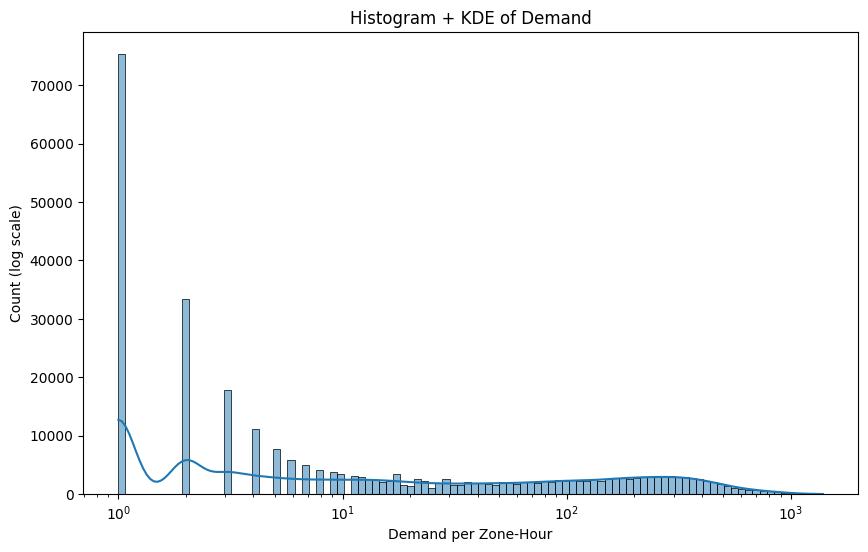

In [2]:
plt.figure(figsize=(10,6))
sns.histplot(demand, bins=100, kde=True, log_scale=True)
plt.xlabel("Demand per Zone-Hour")
plt.ylabel("Count (log scale)")
plt.title("Histogram + KDE of Demand")
plt.show()

### Visual Inspection
- Confirms heavy right-skew and long tail.
- Peaks at low demand values dominate.
- Suggests Poisson-like or lognormal behavior for modeling.

Poisson lambda estimate: 73.80


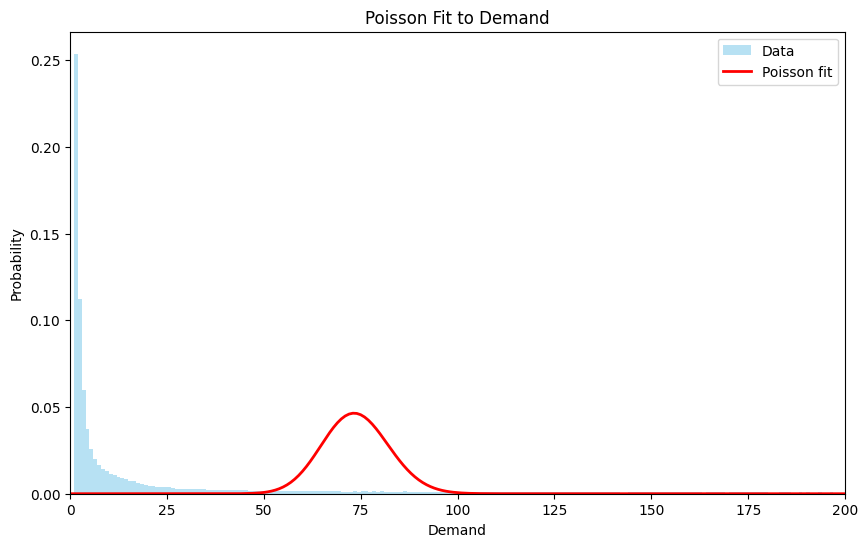

In [4]:
# Estimate Poisson lambda
lambda_poisson = demand.mean()
print(f"Poisson lambda estimate: {lambda_poisson:.2f}")

# Plot
x = np.arange(0, demand.max()+1)
poisson_pmf = stats.poisson.pmf(x, mu=lambda_poisson)

plt.figure(figsize=(10,6))
plt.hist(demand, bins=range(0, int(demand.max())+1), density=True, alpha=0.6, color="skyblue", label="Data")
plt.plot(x, poisson_pmf, 'r-', lw=2, label="Poisson fit")
plt.xlim(0, 200)
plt.xlabel("Demand")
plt.ylabel("Probability")
plt.title("Poisson Fit to Demand")
plt.legend()
plt.show()

### Poisson Fit
- Lambda ~= mean demand per zone-hour
- Poisson underestimates the probability of high-demand peaks due to heavy tail.
- Conclusion: Poisson is a rough first approximation, but inadequate for extreme peaks.

Negative Binomial params: r=0.28, p=0.0037


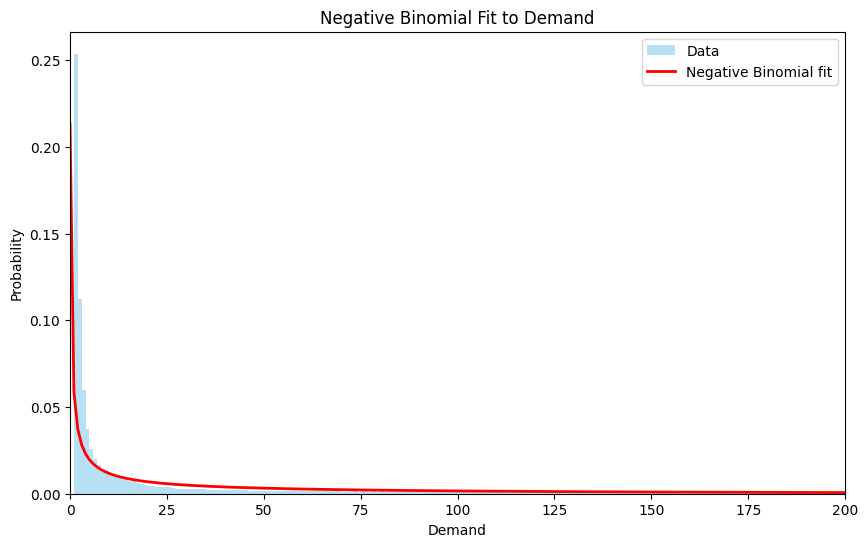

In [5]:
# Fit NB parameters using method of moments
mean_d = demand.mean()
var_d = demand.var()
p_nb = mean_d / var_d
r_nb = mean_d**2 / (var_d - mean_d)
print(f"Negative Binomial params: r={r_nb:.2f}, p={p_nb:.4f}")

# Plot NB PMF
nb_pmf = stats.nbinom.pmf(x, r_nb, p_nb)

plt.figure(figsize=(10,6))
plt.hist(demand, bins=range(0, int(demand.max())+1), density=True, alpha=0.6, color="skyblue", label="Data")
plt.plot(x, nb_pmf, 'r-', lw=2, label="Negative Binomial fit")
plt.xlim(0, 200)
plt.xlabel("Demand")
plt.ylabel("Probability")
plt.title("Negative Binomial Fit to Demand")
plt.legend()
plt.show()

### Negative Binomial Fit
- Captures variance > mean (overdispersion) better than Poisson.
- Matches high-demand tail more closely.
- Provides a statistically defensible choice for probabilistic modeling and Bayesian priors.

Lognormal params: shape=2.1212, loc=0.0000, scale=10.4538


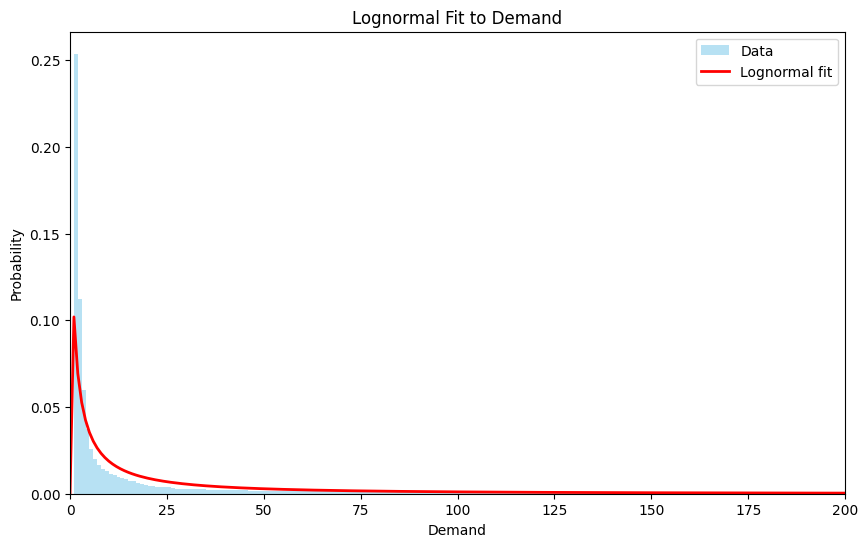

In [6]:
# Fit lognormal
shape, loc, scale = stats.lognorm.fit(demand[demand>0], floc=0)
print(f"Lognormal params: shape={shape:.4f}, loc={loc:.4f}, scale={scale:.4f}")

# Plot PDF
pdf_lognorm = stats.lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(10,6))
plt.hist(demand, bins=range(0, int(demand.max())+1), density=True, alpha=0.6, color="skyblue", label="Data")
plt.plot(x, pdf_lognorm, 'r-', lw=2, label="Lognormal fit")
plt.xlim(0, 200)
plt.xlabel("Demand")
plt.ylabel("Probability")
plt.title("Lognormal Fit to Demand")
plt.legend()
plt.show()

### Lognormal Fit
- Accurately captures the right-skew and heavy tail.
- Works well for modeling demand peaks.
- Can be used as a continuous approximation for probabilistic forecasting.

## Distribution Fitting Summary

| Distribution | Parameters | Fit Quality | Notes |
|-------------|------------|------------|-------|
| Poisson     | λ ≈ mean  | Poor        | Underestimates heavy tail |
| Negative Binomial | r,p via MoM | Better    | Captures overdispersion |
| Lognormal   | shape, scale | Good     | Captures right skew & tail |

**Key Insights:**

- Ride demand is **overdispersed and highly skewed**.
- Poisson is too simplistic; Negative Binomial and Lognormal fit better.